In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from functools import partial

import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt

# Please do not change these random seeds.
np.random.seed(231)
random.seed(231)
model = KNeighborsClassifier(n_neighbors=5)

In [2]:
# --------------------------- Part 1: Load the Data ---------------------------
data_train = pd.read_csv('Training.csv')
X_train, y_train = data_train.drop('Status', axis=1), data_train['Status']

data_test = pd.read_csv('Test.csv')
X_test, y_test = data_test.drop('Status', axis=1), data_test['Status']

In [3]:
# --------------------------- Part 1: Data Preprocessing ---------------------------

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()  # List of numerical feature names
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()  # List of categorical feature names

### Step 1: Handle Missing Values ###
# Define and apply appropriate imputers for numerical and categorical features.
# Ensure consistency between X_train and X_test.

num_imputer = SimpleImputer(strategy='mean') 
X_train_num = num_imputer.fit_transform(X_train[numerical_cols])
X_test_num = num_imputer.transform(X_test[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
X_test_cat = cat_imputer.transform(X_test[categorical_cols])

### Step 2: Encoding Categorical Features ###
# Convert categorical features into numerical format using encoding techniques.

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

### Step 3: Feature Scaling ###
# Apply scaling/normalization to features.

X_train_combined = np.hstack((X_train_num, X_train_cat_encoded))
X_test_combined = np.hstack((X_test_num, X_test_cat_encoded))

X_train_process = StandardScaler().fit_transform(X_train_combined)  # Processed/transformed training set
X_test_process = StandardScaler().fit_transform(X_test_combined)  # Processed/transformed test set

# Train the model using all available features.
model.fit(X_train_process, y_train)
y_pred = model.predict(X_test_process)
print(f"All Features: {balanced_accuracy_score(y_test, y_pred):.4f}")

print(f"Processed X_train shape: {X_train_process.shape}")
print(f"Processed X_test shape: {X_test_process.shape}")

All Features: 0.6815
Processed X_train shape: (334, 24)
Processed X_test shape: (84, 24)


Top 7 selected features (Mutual Information):
1. Bilirubin
2. Copper
3. Alk_Phos
4. Prothrombin
5. Stage
6. Ascites_N
7. Spiders_N
Performance using top 7 features: 0.7007


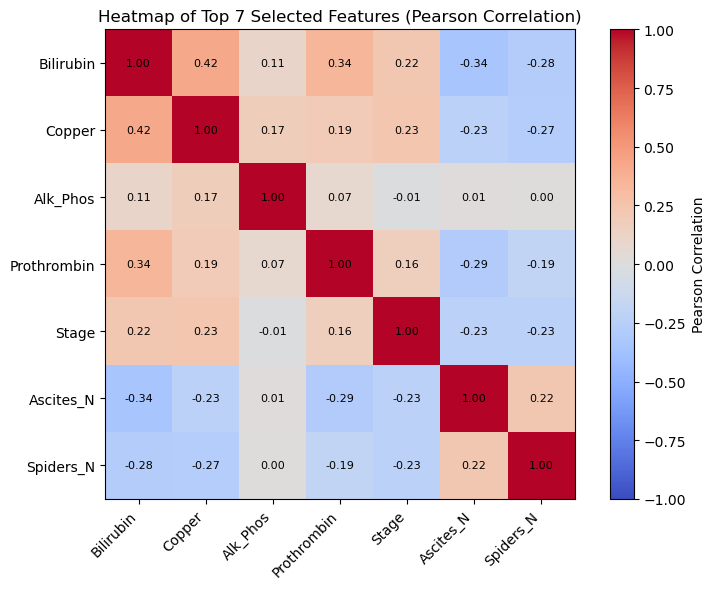

In [7]:
# --------------------------- Part 2: Feature Ranking ---------------------------
# Use SelectKBest with mutual_info_classif to select the top 7 features from the processed training set X_train_process.
# You should use mutual_info_fix as the parameter for SelectKBest to ensure random_state is set to 231 for reproducibility.
mutual_info_fix = partial(mutual_info_classif, random_state=231)
selector_kbest = SelectKBest(score_func = mutual_info_fix, k = 7)  # Replace [] with SelectKBest implementation
X_train_kbest = selector_kbest.fit_transform(X_train_process, y_train)  # Replace [] with transformed training data
X_test_kbest = selector_kbest.transform(X_test_process)  # Replace [] with transformed test data

mask = selector_kbest.get_support()
all_feature_names = numerical_cols + list(encoder.get_feature_names_out(categorical_cols))
selected_feature_names = [name for name, selected in zip(all_feature_names, mask) if selected]

print("Top 7 selected features (Mutual Information):")
for i, name in enumerate(selected_feature_names, 1):
    print(f"{i}. {name}")

# Train the model with selected features.
model.fit(X_train_kbest, y_train)
y_pred_kbest = model.predict(X_test_kbest)
acc_kbest = balanced_accuracy_score(y_test, y_pred_kbest)

print(f"Performance using top 7 features: {acc_kbest:.4f}")

# Compute Pearson correlation matrix of selected features
corr_matrix = np.corrcoef(X_train_kbest, rowvar=False)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im, label='Pearson Correlation')
plt.title("Heatmap of Top 7 Selected Features (Pearson Correlation)")

# Axis ticks
plt.xticks(ticks=np.arange(len(selected_feature_names)), labels=selected_feature_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(selected_feature_names)), labels=selected_feature_names)

# Overlay correlation values
for i in range(len(selected_feature_names)):
    for j in range(len(selected_feature_names)):
        value = corr_matrix[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

Sequential Feature Selection: 0.5986

Top 1 selected features (SBS):
1. Cholesterol
2. Prothrombin
3. Stage
4. Drug_D-penicillamine
5. Drug_Placebo
6. Sex_M
7. Spiders_Y


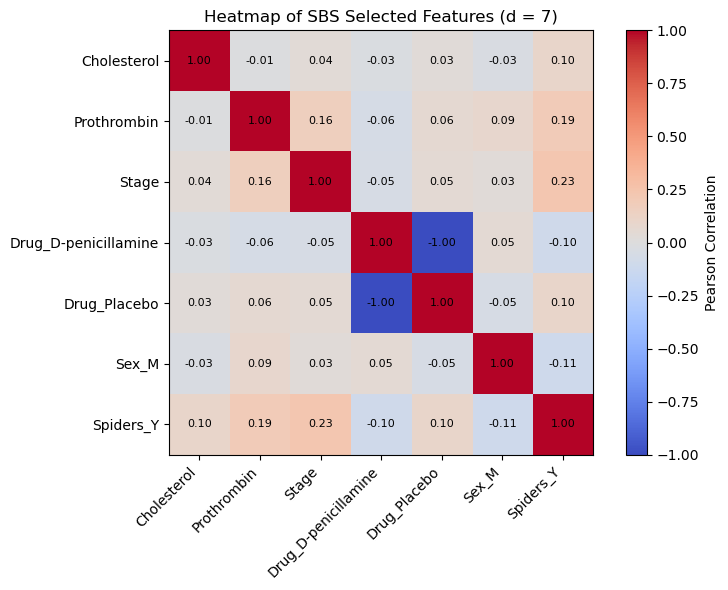

d = 1, Balanced Accuracy: 0.5829
d = 3, Balanced Accuracy: 0.6178
d = 7, Balanced Accuracy: 0.5986
d = 12, Balanced Accuracy: 0.6466
d = 17, Balanced Accuracy: 0.6815


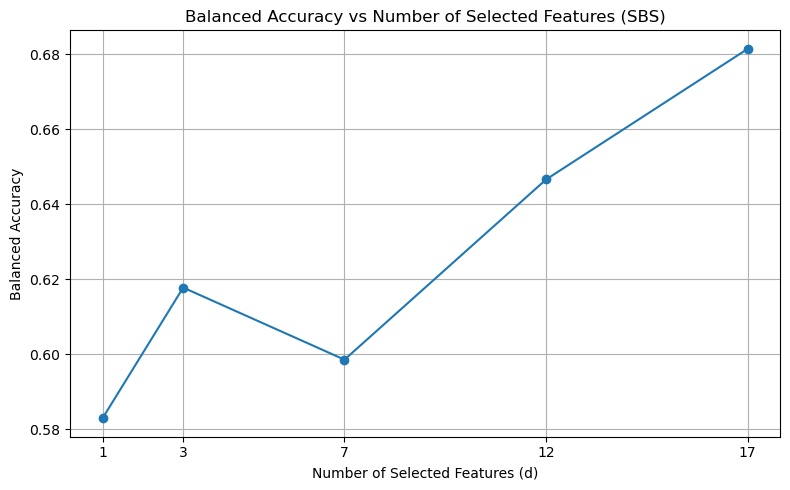

In [15]:
# --------------------------- Part 3: Sequential Feature Selection ---------------------------
# Use Sequential Backward Selection (SBS) to select a subset of 7 features from the processed training set X_train_process.
selector_sequential = SequentialFeatureSelector(model, n_features_to_select=7, direction='backward')  # Replace [] with SequentialFeatureSelector implementation
X_train_sbfs = selector_sequential.fit_transform(X_train_process, y_train)  # Replace [] with transformed training data
X_test_sbfs = selector_sequential.transform(X_test_process)  # Replace [] with transformed test data

# Train the model with selected features.
model.fit(X_train_sbfs, y_train)
y_pred = model.predict(X_test_sbfs)
acc_sbs = balanced_accuracy_score(y_test, y_pred)
print(f"Sequential Feature Selection: {balanced_accuracy_score(y_test, y_pred):.4f}")

# Get feature names
mask_sbs = selector_sequential.get_support()
sbs_selected_feature_names = [name for name, selected in zip(all_feature_names, mask_sbs) if selected]

print("\nTop 1 selected features (SBS):")
for i, name in enumerate(sbs_selected_feature_names, 1):
    print(f"{i}. {name}")

# Pearson correlation heatmap for SBS-selected features
X_train_sbs_named = X_train_process[:, mask_sbs]
corr_matrix_sbs = np.corrcoef(X_train_sbs_named, rowvar=False)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix_sbs, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, label='Pearson Correlation')
plt.title("Heatmap of SBS Selected Features (d = 7)")
plt.xticks(np.arange(7), labels=sbs_selected_feature_names, rotation=45, ha='right')
plt.yticks(np.arange(7), labels=sbs_selected_feature_names)

# Show values inside the heatmap cells
for i in range(7):
    for j in range(7):
        value = corr_matrix_sbs[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

# Part 6b

feature_counts = [1, 3, 7, 12, 17]
accuracies = []

for d in feature_counts:
    selector = SequentialFeatureSelector(model, n_features_to_select=d, direction='backward')
    X_train_d = selector.fit_transform(X_train_process, y_train)
    X_test_d = selector.transform(X_test_process)
    
    model.fit(X_train_d, y_train)
    y_pred_d = model.predict(X_test_d)
    acc_d = balanced_accuracy_score(y_test, y_pred_d)
    accuracies.append(acc_d)
    
    print(f"d = {d}, Balanced Accuracy: {acc_d:.4f}")

# Plot accuracy vs number of selected features
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o', linestyle='-')
plt.title("Balanced Accuracy vs Number of Selected Features (SBS)")
plt.xlabel("Number of Selected Features (d)")
plt.ylabel("Balanced Accuracy")
plt.grid(True)
plt.xticks(feature_counts)
plt.tight_layout()
plt.show()